# Designing a bathymetry-conforming mesh

This notebook shows how to setup a 2-D mesh which fits topography. It is recommended that you first go through the previous tutorials before this one.

*Created by A. Grayver, 2020*

Let us start by including some common packages

In [ ]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

In [2]:
module_path = os.path.abspath('/home/agrayver/lib/dealii/build_gofem/lib/python3.7/site-packages')
if module_path not in sys.path:
    sys.path.append(module_path)

import PyDealII.Release as dealii

from gofem.parameter_handler import *
from gofem.mesh_utils import *

In [3]:
dy = np.ones(shape = 5) * 2000
dz = np.ones(shape = 4) * 1600
mesh_size = np.array([np.sum(dy), np.sum(dz)])

p_origin = dealii.Point((-mesh_size / 2.).tolist())
p_end = dealii.Point((mesh_size / 2.).tolist())

triangulation = dealii.Triangulation('2D')
triangulation.generate_subdivided_steps_hyper_rectangle([dy.tolist(), dz.tolist()], p_origin, p_end, False)
triangulation.refine_global(2)

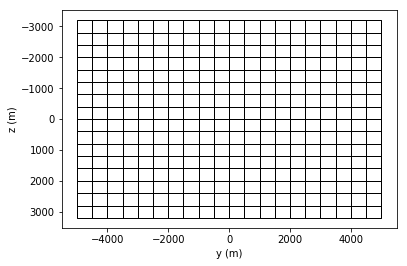

In [4]:
fig, ax = plot_2d_triangulation(triangulation)

In [5]:
materials = {1: ('air', 1e-8), 2: ('sea', 3.2), 3: ('ground', 0.5)}

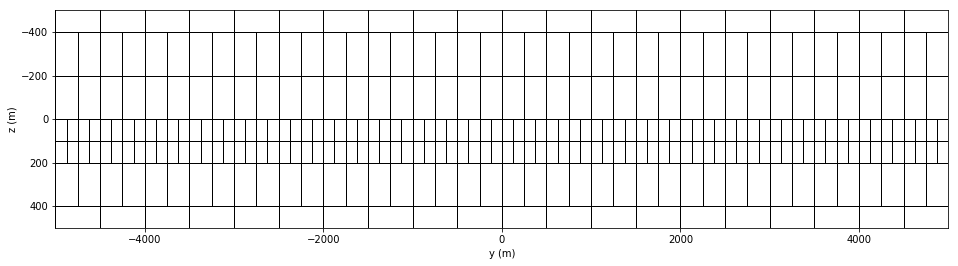

In [6]:
for cell in triangulation.active_cells():
    if cell.center().y < 0:
        cell.material_id = 1
    else:
        cell.material_id = 3
        
refine_at_interface(triangulation, material_ids = [3], repeat = 2, center = [0,0], radii = [6000])
fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-5000, 5000])
ax.set_ylim([-500, 500])
ax.invert_yaxis()
fig.set_size_inches(16,4)

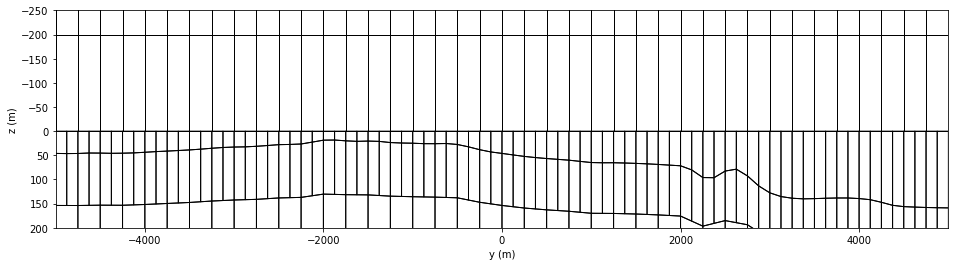

In [7]:
data = np.loadtxt('2D_Bathymetry_Model.txt', delimiter = '\t')

bathymetry_func = RegularGridInterpolator((np.squeeze(data[:,0]),), np.squeeze(data[:,1]), bounds_error = False)

def bathymetry_callback(p):
    return bathymetry_func([p])[0]

topo = Topography(bathymetry_callback, dim = 2, center = [0, 0], radius = [6000, 6000])

z_mean_bathymetry = 100 # should lie at the flat mesh edges
topo.fit_to(triangulation, z_top = 0, z_bottom = 800, z_mean_bathymetry = z_mean_bathymetry)

fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-5000, 5000])
ax.set_ylim([-250, 200])
ax.invert_yaxis()
fig.set_size_inches(16, 4)

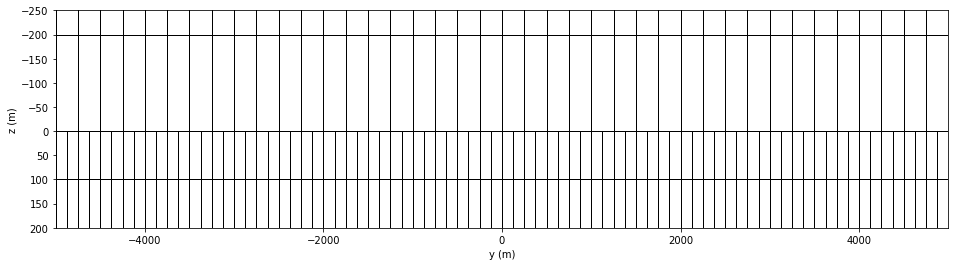

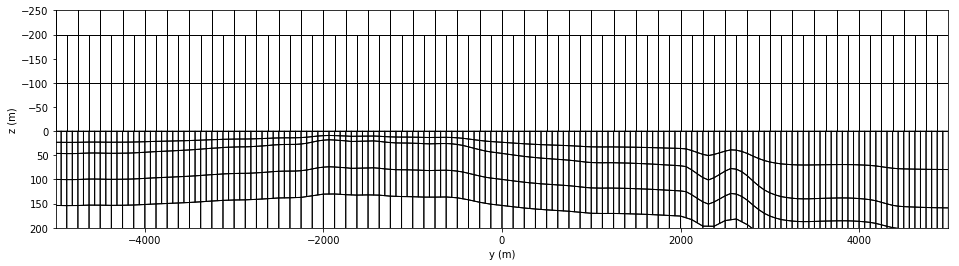

In [8]:
for cell in triangulation.active_cells():
    p_center = cell.center()
    if p_center.y < 0:
        cell.material_id = 1
    elif p_center.y > 0 and p_center.y < bathymetry_callback((p_center.x)):
        cell.material_id = 2
    else:
        cell.material_id = 3
        
topo.fit_to(triangulation, z_top = 0, z_bottom = 800, z_mean_bathymetry = z_mean_bathymetry, inverse = True)

fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-5000, 5000])
ax.set_ylim([-250, 200])
ax.invert_yaxis()
fig.set_size_inches(16, 4)

refine_at_interface(triangulation, material_ids = [2], repeat = 1, center = [0,0], radius = [6000])
refine_at_interface(triangulation, material_ids = [3], repeat = 1, center = [0,0], radius = [6000])

topo.fit_to(triangulation, z_top = 0, z_bottom = 800, z_mean_bathymetry = z_mean_bathymetry)

fig, ax = plot_2d_triangulation(triangulation)
ax.set_xlim([-5000, 5000])
ax.set_ylim([-250, 200])
ax.invert_yaxis()
fig.set_size_inches(16, 4)

In [9]:
receivers_y = np.arange(-4000., 4000.1, 400.)
receivers = []
for ry in receivers_y:
    receivers.append([ry, bathymetry_callback((ry))])

mapping = dealii.MappingQGeneric(dim = 2, spacedim = 2, degree = 1)
receivers_projected = project_points_on_interface(triangulation = triangulation, points = receivers, material_id = 2, mapping = mapping)

receivers_y = []
receivers_z = []
for r in receivers_projected:
    receivers_y.append(r[0])
    receivers_z.append(r[1] - 1.)

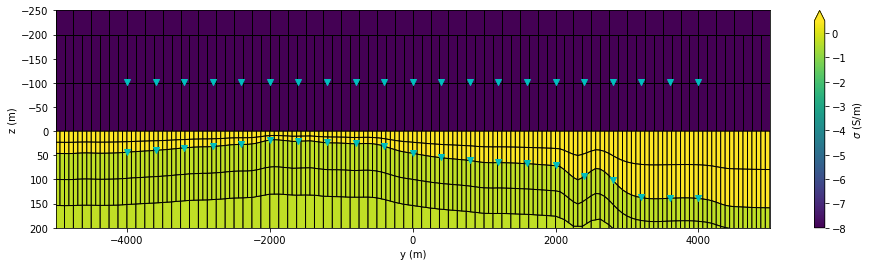

In [10]:
def color(cell):
    return math.log10(materials[cell.material_id][1])

fig, ax = plot_2d_triangulation(triangulation, color_scheme=color)
ax.set_xlim([-5000, 5000])
ax.set_ylim([-250, 200])
ax.invert_yaxis()
ax.scatter(receivers_y, receivers_z, color='c', marker='v')
fig.set_size_inches(16, 4)
fig.colorbar(ax.collections[0], ax=ax,\
             orientation = 'vertical',\
             label = r'$\sigma$ (S/m)',\
             extend='max')